In [1]:
import numpy as np
import matplotlib.pyplot as plt

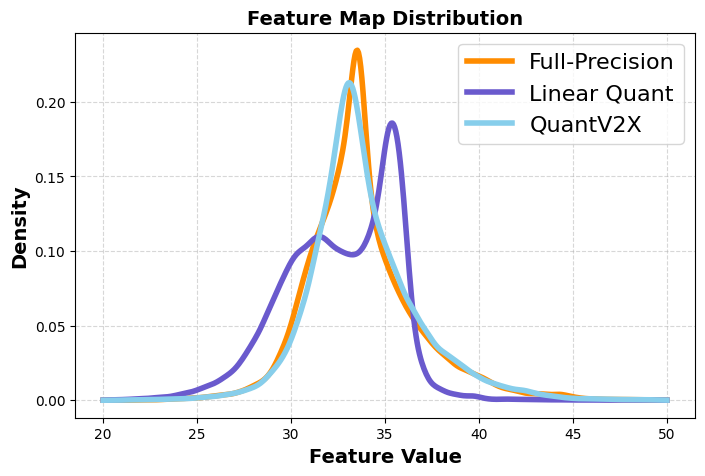

In [2]:
# Define the steps and their corresponding colors
import os


steps = ["fp", "minmax", "quantv2x"]
labels = ['Full-Precision', 'Linear Quant', 'QuantV2X']
colors = ['darkorange', 'slateblue', 'skyblue']

# steps = ["fp", "minmax", "quantv2x"]
# colors = ['orange', 'purple', 'cyan']

plt.figure(figsize=(8, 5))

# Loop through each step and plot it
for step, label, color in zip(steps, labels, colors):
    file_path = f"./logs_dairv2x_quant/collab_base/pointpillar_liftsplatshoot/Pyramid40/featfile_{step}.npz"
    data = np.load(file_path)
    x = data['x']
    y = data['y']
    plt.plot(x, y, color=color, linewidth=4, label=f'{label}')

# Final plot settings
plt.title("Feature Map Distribution", fontsize=14, fontweight='bold')
plt.xlabel('Feature Value', fontsize=14, fontweight='bold')
plt.ylabel('Density', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=16)
save_path = os.path.join("./pplss_distribution_comp.png")
plt.savefig(save_path)
plt.show()

In [27]:
import time

import cv2
import numpy as np
import open3d as o3d
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from opencood.utils import box_utils
from opencood.utils import common_utils
from opencood.visualization.vis_utils_mc import bbx2oabb, save_o3d_visualization


def visualize_single_sample_output_gt(pred_box_tensor1,
                                      pred_box_tensor2,
                                      pred_box_tensor3,
                                      gt_box_tensor,
                                      origin_lidar,
                                      map_lidar,
                                      show_vis=True,
                                      save_path='',
                                      mode='constant',
                                      colors=None):
    """
    Visualize the prediction, groundtruth with point cloud together.

    Parameters
    ----------
    pred_box_tensor : torch.Tensor
        (N, 8, 3) prediction.

    gt_box_tensor : torch.Tensor
        (N, 8, 3) groundtruth bbx

    pcd : torch.Tensor
        PointCloud, (N, 4).

    show_vis : bool
        Whether to show visualization.

    save_path : str
        Save the visualization results to given path.

    mode : str
        Color rendering mode.
    """

    def custom_draw_geometry(pcd, pred1, pred2, pred3, gt, new_origin=None):
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.get_render_option().line_width = 4

        opt = vis.get_render_option()
        opt.background_color = np.asarray([0, 0, 0])
        opt.point_size = 1.0  # 1.0
        opt.line_width = 40
        
        vis.add_geometry(pcd)
        for ele in pred1:
            vis.add_geometry(ele)
        for ele in pred2:
            vis.add_geometry(ele)
        for ele in pred3:
            vis.add_geometry(ele)
        for ele in gt:
            vis.add_geometry(ele)

        # Set the new origin for rotation if provided
        ctr = vis.get_view_control()
        if new_origin is not None:
            print(f"Setting rotation origin to: {new_origin}")
            ctr.set_lookat(new_origin)
        else:
            print("Using default rotation origin (center of the bounding box)")

        vis.run()
        vis.destroy_window()

    lidar_list = []
    for lidar_data in origin_lidar:
        if not isinstance(lidar_data, np.ndarray):
            lidar_data = common_utils.torch_tensor_to_numpy(lidar_data)
        # we only visualize the first cav for single sample
        if len(lidar_data.shape) > 2:
            lidar_data = lidar_data[0]
        # this is for 2-stage origin lidar, it has different format
        if lidar_data.shape[1] > 4:
            lidar_data = lidar_data[:, 1:]
        # left -> right hand
        lidar_data[:, :1] = -lidar_data[:, :1]
        lidar_list.append(lidar_data)
    if map_lidar:
        if not isinstance(map_lidar, np.ndarray):
            map_lidar = common_utils.torch_tensor_to_numpy(map_lidar)
        # we only visualize the first cav for single sample
        if len(map_lidar.shape) > 2:
            map_lidar = map_lidar[0]
        # this is for 2-stage origin lidar, it has different format
        if map_lidar.shape[1] > 4:
            map_lidar = map_lidar[:, 1:]
        # left -> right hand
        map_lidar[:, :1] = -map_lidar[:, :1]

    if not isinstance(pred_box_tensor1, np.ndarray):
        pred_box_tensor1 = common_utils.torch_tensor_to_numpy(pred_box_tensor1)
    if not isinstance(gt_box_tensor, np.ndarray):
        gt_box_tensor = common_utils.torch_tensor_to_numpy(gt_box_tensor)
    if not isinstance(pred_box_tensor2, np.ndarray):
        pred_box_tensor2 = common_utils.torch_tensor_to_numpy(pred_box_tensor2)
    if not isinstance(pred_box_tensor3, np.ndarray):
        pred_box_tensor3 = common_utils.torch_tensor_to_numpy(pred_box_tensor3)

    # colors = [
    #     [1, 0.7, 0],
    #     [0, 0.7, 0],
    #     [0, 0.7, 1],
    #     [0.7, 0, 0.7],
    #     [0, 0.5, 1],
    #     [0.9, 0.9, 0.9]
    # ]
    colors=  [[255,255,255], [255,255,255], [255,255,255], [255,255,255]]
    # colors = [[120, 120, 120], [120, 120, 120], [120, 120, 120], [120, 120, 120]]
    colors = np.array(colors) / 255
    pcds = o3d.geometry.PointCloud()
    for i, lidar_data in enumerate(lidar_list):
        lidar_pcd = o3d.geometry.PointCloud()
        lidar_pcd.points = o3d.utility.Vector3dVector(lidar_data[:, :3])
        lidar_pcd.paint_uniform_color(colors[i])
        pcds += lidar_pcd
    if map_lidar:
        map_pcd = o3d.geometry.PointCloud()
        map_pcd.points = o3d.utility.Vector3dVector(map_lidar[:, :3])

        map_pcd.paint_uniform_color(colors[-1])

        pcds+= map_pcd

    """
    (25, 8, 3)
    (61, 8, 3)
    """
    if pred_box_tensor1 is not None:
        oabbs_pred1 = bbx2oabb(pred_box_tensor1, color=(1.0, 0.5, 0.0)) # orange for fp
    else:
        oabbs_pred1 = []

    if pred_box_tensor2 is not None:
        oabbs_pred2 = bbx2oabb(pred_box_tensor2, color=(0.9, 0.0, 0.9)) # purple for minmax
    else:
        oabbs_pred2 = []

    if pred_box_tensor3 is not None:
        oabbs_pred3 = bbx2oabb(pred_box_tensor3, color=(0.0, 0.9, 0.9)) # blue for quantv2x
    else:
        oabbs_pred3 = []

    oabbs_gt = bbx2oabb(gt_box_tensor, color=(0, 1, 0))

    visualize_elements = [pcds] + oabbs_pred1 + oabbs_gt
    if show_vis:
        custom_draw_geometry(pcds, oabbs_pred1, oabbs_pred2, oabbs_pred3, oabbs_gt, new_origin=[0, 0, 0])
    if save_path:
        save_o3d_visualization(visualize_elements, save_path)

In [28]:
import numpy as np

# Define the path where your .npy files are saved
npy_save_path = "./logs_v2xreal_quant_compr/v2v_compr_x1/npy"

# Load the first model's files
timestamp1 = "fp"
pcd_np1 = np.load(f"{npy_save_path}/{timestamp1}_pcd.npy")
pred_np1 = np.load(f"{npy_save_path}/{timestamp1}_pred.npy")
gt_np1 = np.load(f"{npy_save_path}/{timestamp1}_gt.npy_test.npy")

# Load the second model's files
timestamp2 = "minmax"
pcd_np2 = np.load(f"{npy_save_path}/{timestamp2}_pcd.npy")
pred_np2 = np.load(f"{npy_save_path}/{timestamp2}_pred.npy")
gt_np2 = np.load(f"{npy_save_path}/{timestamp2}_gt.npy_test.npy")

# Load the third model's files
timestamp3 = "quantv2x"
pcd_np3 = np.load(f"{npy_save_path}/{timestamp3}_pcd.npy")
pred_np3 = np.load(f"{npy_save_path}/{timestamp3}_pred.npy")
gt_np3 = np.load(f"{npy_save_path}/{timestamp3}_gt.npy_test.npy")

print("Model 1 (FP) - Loaded Point Cloud Shape:", pcd_np1.shape)
print("Model 1 (FP) - Loaded Prediction Boxes Shape:", pred_np1.shape)
print("Model 1 (FP) - Loaded Ground Truth Boxes Shape:", gt_np1.shape)

print("Model 2 (MinMax) - Loaded Point Cloud Shape:", pcd_np2.shape)
print("Model 2 (MinMax) - Loaded Prediction Boxes Shape:", pred_np2.shape)
print("Model 2 (MinMax) - Loaded Ground Truth Boxes Shape:", gt_np2.shape)



Model 1 (FP) - Loaded Point Cloud Shape: (441605, 3)
Model 1 (FP) - Loaded Prediction Boxes Shape: (177, 8, 3)
Model 1 (FP) - Loaded Ground Truth Boxes Shape: (69, 8, 3)
Model 2 (MinMax) - Loaded Point Cloud Shape: (441605, 3)
Model 2 (MinMax) - Loaded Prediction Boxes Shape: (62, 8, 3)
Model 2 (MinMax) - Loaded Ground Truth Boxes Shape: (69, 8, 3)


In [29]:
print("Model 1 (FP) - X Range:", pred_np1[:, :, 0].min(), pred_np1[:, :, 0].max())
print("Model 1 (FP) - Y Range:", pred_np1[:, :, 1].min(), pred_np1[:, :, 1].max())

print("Model 2 (MinMax) - X Range:", pred_np2[:, :, 0].min(), pred_np2[:, :, 0].max())
print("Model 2 (MinMax) - Y Range:", pred_np2[:, :, 1].min(), pred_np2[:, :, 1].max())

Model 1 (FP) - X Range: -92.72166 97.73993
Model 1 (FP) - Y Range: -35.23457 26.816502
Model 2 (MinMax) - X Range: -70.27488 97.69012
Model 2 (MinMax) - Y Range: -20.634537 25.542421


In [30]:

# Create a list of lidar data (expected by the function)
origin_lidar = [pcd_np1]  # Since it's a single sample, it's just one entry in the list
map_lidar = None  # If you do not have map lidar data

# Visualize the loaded data
visualize_single_sample_output_gt(pred_box_tensor1=pred_np1,
                                  pred_box_tensor2=pred_np2,
                                  pred_box_tensor3=pred_np3,
                                  gt_box_tensor=gt_np1,
                                  origin_lidar=origin_lidar,
                                  map_lidar=map_lidar,
                                  show_vis=True)

Setting rotation origin to: [0, 0, 0]
